# Week 3 - Network Models

In [142]:
import numpy as np
import pandas as pd
from pulp import *

## 1) Transportation problem

An automobile company manufactures cars in 3 plants and then ships them to 4 regions.   
The plants can supply the amount listed in `capacity`.  
The customer demands by region are listed in `demand`.  
And the unit costs of shipping a car from each plant to each region are listed in `unit costs`.  
The company wants to find the lowest-cost shipping plan for meeting the demands of the four regions without exceeding the capacities of the plants.

### Input parameters

In [143]:
capacity = np.array([450, 600, 500])
capacity = dict(zip(plants, capacity))
print('Capacity:\n', capacity)
demand = np.array([450, 200, 300, 300])
demand = dict(zip(regions, demand))
print('Demand:\n', demand)

Capacity:
 {'Plant1': 450, 'Plant2': 600, 'Plant3': 500}
Demand:
 {'Region1': 450, 'Region2': 200, 'Region3': 300, 'Region4': 300}


In [144]:
# i - plants
# j - regions
unit_costs = np.array([
    [131, 218, 266, 120],
    [250, 116, 263, 278],
    [178, 132, 122, 180]
])
plants = [ f"Plant{i}" for i in range(1,4) ]
regions = [ f"Region{j}" for j in range(1,5) ]
unit_costs = pd.DataFrame(unit_costs, index=plants, columns=regions)
unit_costs

,Region1,Region2,Region3,Region4
Plant1,131,218,266,120
Plant2,250,116,263,278
Plant3,178,132,122,180


### Problem formulation

$\text{Decision variables}\\
x_{ij} = \text{flow from i to j for i = 1,2,3 and j = 1,2,3,4}
$

$\text{min}\quad \sum_{i=1}^3 \sum_{j=1}^{4} c_{ij} x_{ij}\\
\text{subject to:}$
\begin{align*}
\sum_{j=1}^4 x_{ij} & \leq b_i && \text{for i = 1, 2, 3} && \text{Capacity}\\
\sum_{i=1}^3 x_{ij} & \geq d_j && \text{for j = 1, 2, 3, 4} && \text{Demand}\\
x_{ij} & \geq 0 && \text{for i = 1, 2, 3 and j = 1, 2, 3, 4} && \text{Nonnegativity}
\end{align*}

### Solve

In [145]:
# Model creation
model = LpProblem('Transportation', LpMinimize)

# decision variables
decision_vars = LpVariable.matrix('x', [f"{i}{j}" for i in range(1,4) for j in range(1,5)], lowBound=0)
allocation = np.array(decision_vars).reshape(len(plants), len(regions))

# objective function
obj_func = lpSum(unit_costs.values * allocation)
model += obj_func

# for each plant, create capacity constraint
for i, plant in enumerate(plants):
    model += lpSum(allocation[i,:]) <= capacity[plant], f"Capactiy {plant}"
    
# for each region, create demand constraint
for j, region in enumerate(regions):
    model += lpSum(allocation[:,j]) >= demand[region], f"Demand {region}"

print(model)

# Solve Model
model.solve()
print(f"Status: {LpStatus[model.status]}")
print(f"Objective value: {model.objective.value()}")

Transportation:
MINIMIZE
131*x_11 + 218*x_12 + 266*x_13 + 120*x_14 + 250*x_21 + 116*x_22 + 263*x_23 + 278*x_24 + 178*x_31 + 132*x_32 + 122*x_33 + 180*x_34 + 0
SUBJECT TO
Capactiy_Plant1: x_11 + x_12 + x_13 + x_14 <= 450

Capactiy_Plant2: x_21 + x_22 + x_23 + x_24 <= 600

Capactiy_Plant3: x_31 + x_32 + x_33 + x_34 <= 500

Demand_Region1: x_11 + x_21 + x_31 >= 450

Demand_Region2: x_12 + x_22 + x_32 >= 200

Demand_Region3: x_13 + x_23 + x_33 >= 300

Demand_Region4: x_14 + x_24 + x_34 >= 300

VARIABLES
x_11 Continuous
x_12 Continuous
x_13 Continuous
x_14 Continuous
x_21 Continuous
x_22 Continuous
x_23 Continuous
x_24 Continuous
x_31 Continuous
x_32 Continuous
x_33 Continuous
x_34 Continuous

Status: Optimal
Objective value: 176050.0


### Result

In [146]:
result = np.array([ v.value() for v in model.variables()]).reshape(len(plants), len(regions))
result = pd.DataFrame(result, index=plants, columns=regions)
result

,Region1,Region2,Region3,Region4
Plant1,150.0,0.0,0.0,300.0
Plant2,100.0,200.0,0.0,0.0
Plant3,200.0,0.0,300.0,0.0


In [192]:
G.nodes()

NodeView(('Plant1', 'Plant2', 'Plant3', 'Region1', 'Region2', 'Region3', 'Region4'))

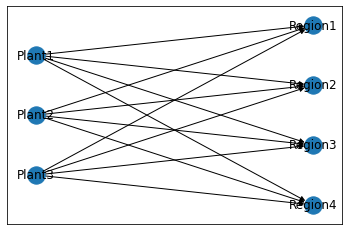

In [191]:
G = nx.DiGraph()
G.add_nodes_from([(p, {'type': 0}) for p in plants])
G.add_nodes_from([(r, {'type': 1}) for r in regions])

df = result.rename_axis('origin').reset_index().melt(id_vars='origin', var_name='destination')
G.add_edges_from([(r.origin, r.destination, {'weight': r.value})for i,r in df.iterrows()])

pos = nx.multipartite_layout(G, subset_key='type')
nx.draw_networkx(G, pos, with_labels=False)
plt.show()

In [174]:
df = result.rename_axis('origin').reset_index().melt(id_vars='origin', var_name='destination')
[ (r.origin, r.destination, {'weight': r.value})for i,r in df.iterrows() ]


[('Plant1', 'Region1', {'weight': 150.0}),
 ('Plant2', 'Region1', {'weight': 100.0}),
 ('Plant3', 'Region1', {'weight': 200.0}),
 ('Plant1', 'Region2', {'weight': 0.0}),
 ('Plant2', 'Region2', {'weight': 200.0}),
 ('Plant3', 'Region2', {'weight': 0.0}),
 ('Plant1', 'Region3', {'weight': 0.0}),
 ('Plant2', 'Region3', {'weight': 0.0}),
 ('Plant3', 'Region3', {'weight': 300.0}),
 ('Plant1', 'Region4', {'weight': 300.0}),
 ('Plant2', 'Region4', {'weight': 0.0}),
 ('Plant3', 'Region4', {'weight': 0.0})]

In [173]:
for i,r in result.rename_axis('origin').reset_index().melt(id_vars='origin', var_name='destination').iterrows():
    print(r)

origin          Plant1
destination    Region1
value            150.0
Name: 0, dtype: object
origin          Plant2
destination    Region1
value            100.0
Name: 1, dtype: object
origin          Plant3
destination    Region1
value            200.0
Name: 2, dtype: object
origin          Plant1
destination    Region2
value              0.0
Name: 3, dtype: object
origin          Plant2
destination    Region2
value            200.0
Name: 4, dtype: object
origin          Plant3
destination    Region2
value              0.0
Name: 5, dtype: object
origin          Plant1
destination    Region3
value              0.0
Name: 6, dtype: object
origin          Plant2
destination    Region3
value              0.0
Name: 7, dtype: object
origin          Plant3
destination    Region3
value            300.0
Name: 8, dtype: object
origin          Plant1
destination    Region4
value            300.0
Name: 9, dtype: object
origin          Plant2
destination    Region4
value              0.0
Name: 10, d

In [170]:
[ (a,b,c) for a,b,c in result.rename_axis('origin').reset_index().melt(id_vars='origin', var_name='destination').iterrows() ]

ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt


In [ ]:
nx.draw

In [ ]:


model = LpProblem('Transport', LpMinimize)

# objective functions
model += lpSum([])

model

In [10]:
df = pd.read_csv('RedBrandLogistics.csv')
df

,Origin,Destination,Unit Cost
0,1,2,5.0
1,1,3,3.0
2,1,4,5.0
3,1,5,5.0
4,1,6,20.0
5,1,7,20.0
6,2,1,9.0
7,2,3,9.0
8,2,4,1.0
9,2,5,1.0


In [ ]:
for 